In [1]:
import os
import sys

current_dir = os.getcwd()

parent_dir = os.path.abspath(os.path.join(current_dir, ".."))

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [80]:
from pathlib import Path

from inference.engine import parse_config, load_model

data_path = Path('/Users/anisr/Documents/dead_trees/Poland/RGBNIR/25cm/2022/Images/M-34-57-A-c-1-1_1.tiff')
config_file_path = Path('../configs/inference.txt')

id2label = {0: "alive", 1: "dead"}
conf = parse_config(config_file_path)
model = load_model(conf.model_config, conf.best_model, id2label)

if data_path.suffix.lower() in [".tiff", ".tif"]:
    image_paths = [data_path]
else:
    with open(data_path, "r") as file:
        image_paths = [Path(line.strip()) for line in file.readlines() if line.strip()]

print(image_paths)

2024-09-24 18:30:50,210 - INFO - Loading model configuration...
2024-09-24 18:30:50,211 - INFO - Using config file: /Users/anisr/Documents/TreeSeg/configs/flair_unet_bs8_cs256.txt
2024-09-24 18:30:50,216 - INFO - Configuration successfully loaded.
2024-09-24 18:30:50,217 - INFO - Model configuration loaded.
2024-09-24 18:30:50,218 - INFO - Using device: cpu
2024-09-24 18:30:50,218 - INFO - Loading or resuming model...
2024-09-24 18:30:51,431 - INFO - flair_unet model configured.
2024-09-24 18:30:51,436 - INFO - Model successfully moved to cpu.
2024-09-24 18:30:51,437 - INFO - Adam optimizer configured with learning rate 0.0001.
2024-09-24 18:30:51,437 - INFO - Hybrid loss and metrics (IOU, F-Score) configured.
2024-09-24 18:30:51,440 - INFO - Model, optimizer, criterion, and metrics are set up.
2024-09-24 18:30:51,531 - INFO - Loaded weights from /Users/anisr/Documents/TreeSeg/output/flair_unet/best.weights.pth.


[PosixPath('/Users/anisr/Documents/dead_trees/Poland/RGBNIR/25cm/2022/Images/M-34-57-A-c-1-1_1.tiff')]


In [81]:
from inference.engine import load_and_preprocess_image, sliding_window_inference, threshold_prediction_map, extract_contours, contours_to_geojson, save_geojson

image_path = image_paths[0]

geojson_path = str(image_path).replace("/Images/", "/Predictions/")
geojson_path = os.path.splitext(geojson_path)[0] + ".geojson"
    
image, transform, crs = load_and_preprocess_image(image_path, conf.nir_rgb_order)

#prediction_map = sliding_window_inference(model, image, conf.window_size, conf.stride)
#print(prediction_map.shape)

#binary_mask = threshold_prediction_map(prediction_map, threshold)
#contours = extract_contours(binary_mask)
#geojson_data = contours_to_geojson(contours, transform, crs, os.path.splitext(os.path.basename(image_path))[0])
#save_geojson(geojson_data, geojson_path)


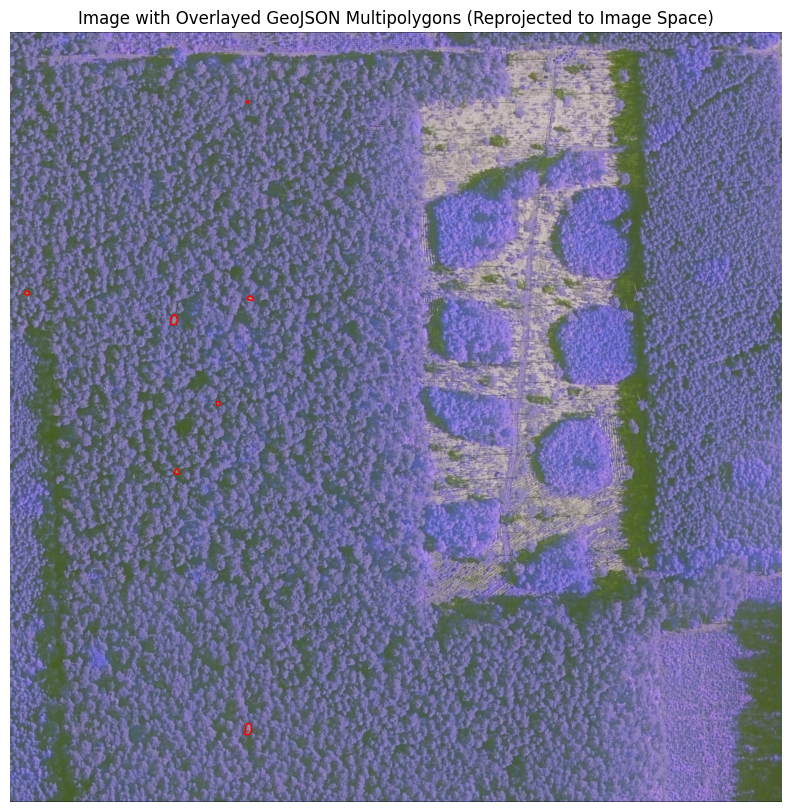

In [151]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import geopandas as gpd
from shapely.affinity import affine_transform

tiff_file = '/Users/anisr/Documents/dead_trees/Poland/RGBNIR/25cm/2022/Images/M-34-57-A-c-1-1_1.tiff'
with rasterio.open(tiff_file) as src:
    image_data = src.read([2, 3, 4])  # Bands 2 (Red), 3 (Green), 4 (Blue)
    
    transform = src.transform
    crs = src.crs

rgb_image = np.dstack([image_data[0], image_data[1], image_data[2]])

geojson_file = '/Users/anisr/Documents/dead_trees/Poland/RGBNIR/25cm/2022/Geojsons/M-34-57-A-c-1-1_1.geojson'
gdf = gpd.read_file(geojson_file)

if gdf.crs != crs:
    gdf = gdf.to_crs(crs)

affine_matrix = [1 / transform.a, 0, 0, 1 / transform.e, -transform.c / transform.a, -transform.f / transform.e]

gdf['geometry'] = gdf['geometry'].apply(lambda geom: affine_transform(geom, affine_matrix))

fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(rgb_image)

gdf.boundary.plot(ax=ax, color='red', linewidth=1)

plt.title("Image with Overlayed GeoJSON Multipolygons (Reprojected to Image Space)")
plt.axis('off')
plt.show()

In [103]:
import torch

import numpy as np
from inference.engine import pad_image, process_batch

model.eval()

device = next(model.parameters()).device  # Get the device of the model

padded_image = pad_image(image, conf.window_size)

_, h, w = padded_image.shape
prediction_map = np.zeros((h, w), dtype=np.float32)
count_map = np.zeros((h, w), dtype=np.float32)

patches = []
coords = []

for y in range(0, h - conf.window_size + 1, conf.stride):
    for x in range(0, w - conf.window_size + 1, conf.stride):
        patch = padded_image[:, y : y + conf.window_size, x : x + conf.window_size]
        patches.append(patch)
        coords.append((y, x))

len(patches)

289

In [107]:
batch_tensor = torch.from_numpy(np.array(patches[:3])).float().to(device)

with torch.no_grad():
    outputs = model(batch_tensor)
    predictions = torch.sigmoid(outputs).squeeze(1).cpu().numpy()

for i, (y, x) in enumerate(coords[:3]):
    confidence = predictions[i]
    mask = (confidence >= 0.5).astype(np.float32)
    prediction_map[y : y + confidence.shape[0], x : x + confidence.shape[1]] += confidence
    count_map[y : y + confidence.shape[0], x : x + confidence.shape[1]] += mask

#count_map[count_map == 0] = 1  # Avoid division by zero
#prediction_map /= count_map
#prediction_map = np.maximum(prediction_map, count_map)

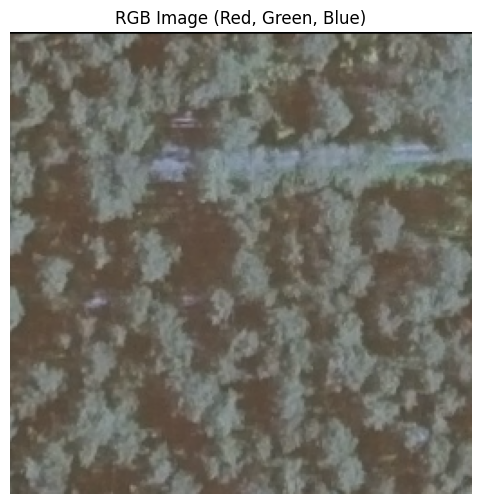

In [120]:
plot_rgb(batch_tensor[0])

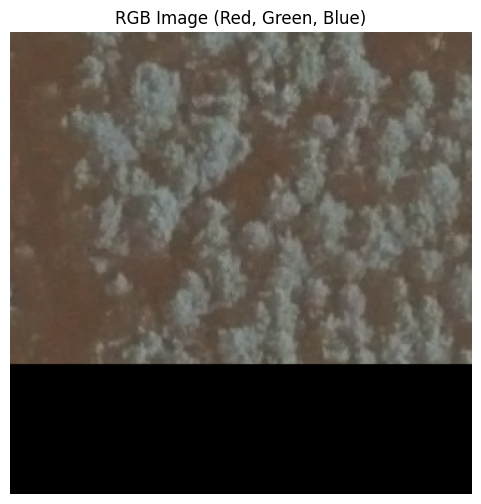

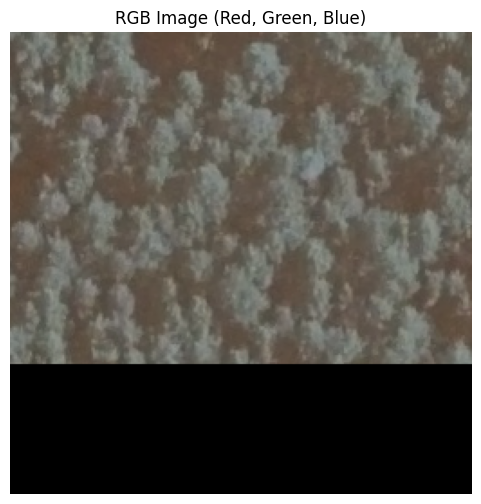

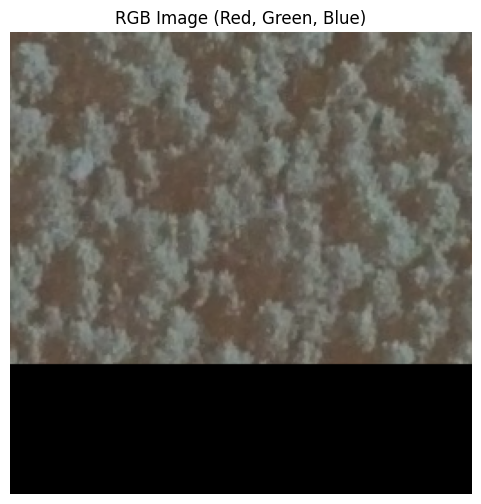

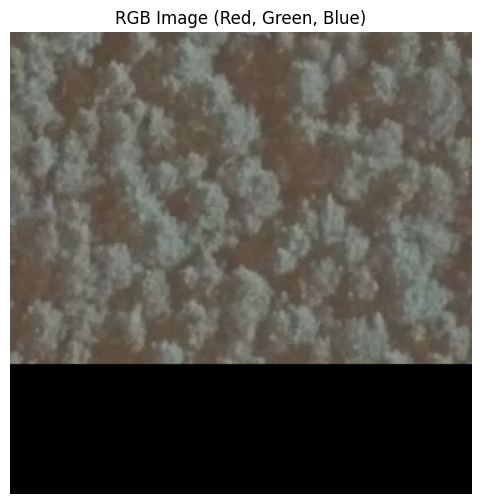

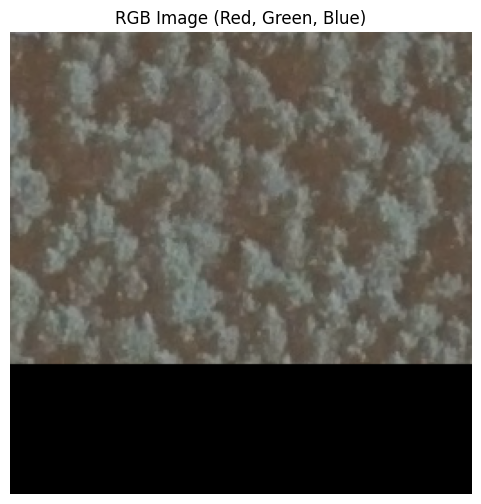

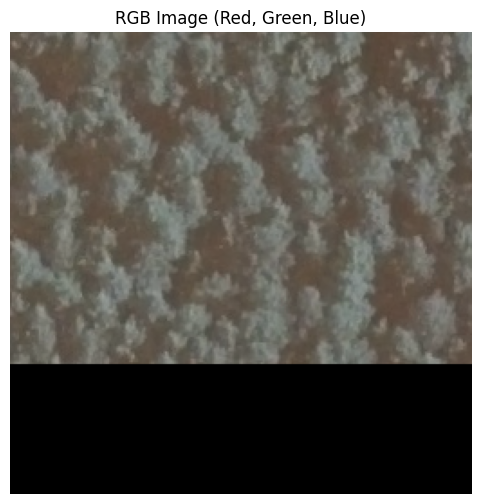

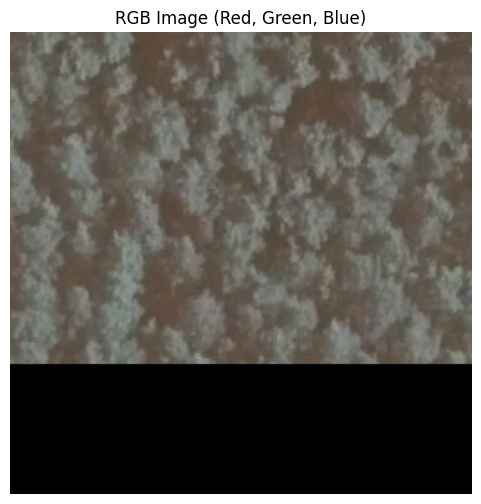

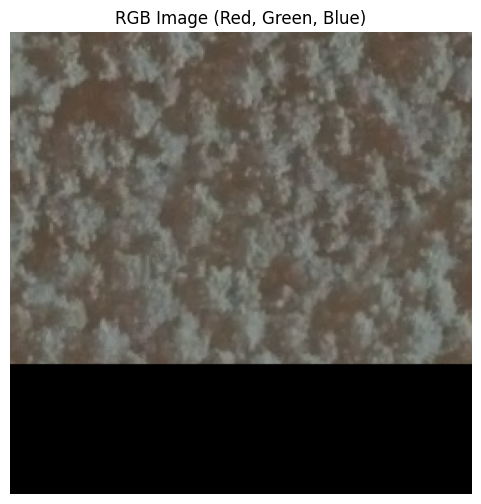

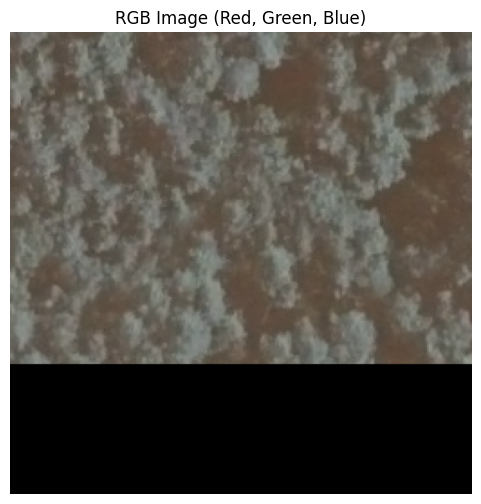

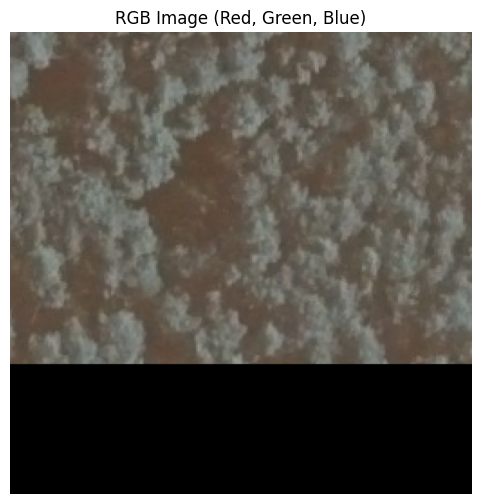

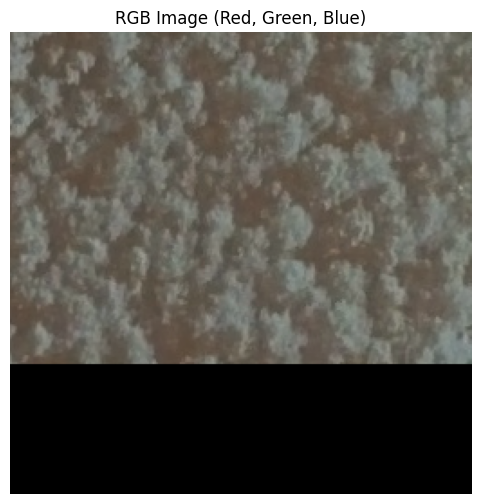

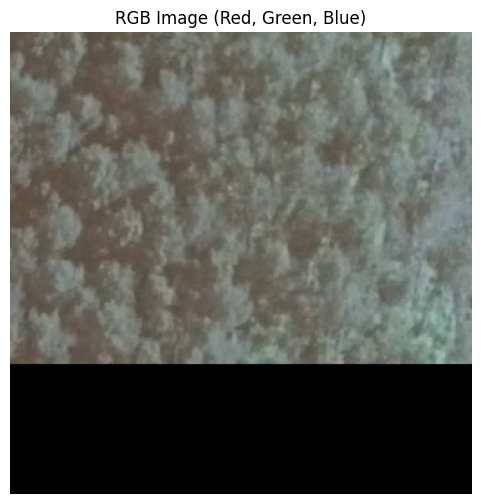

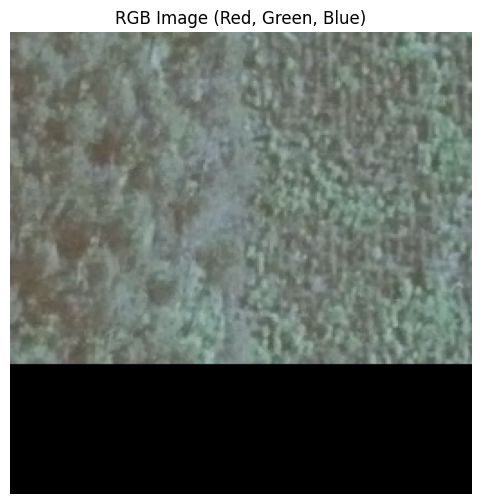

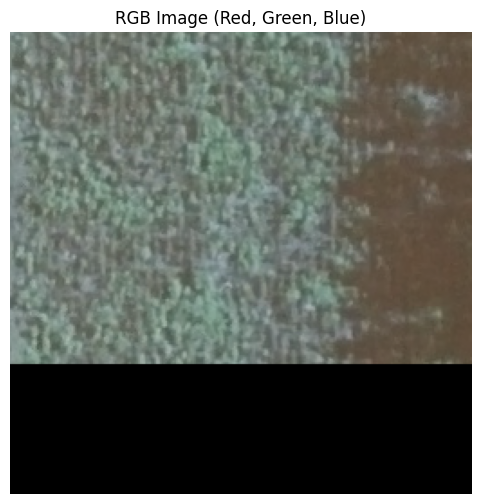

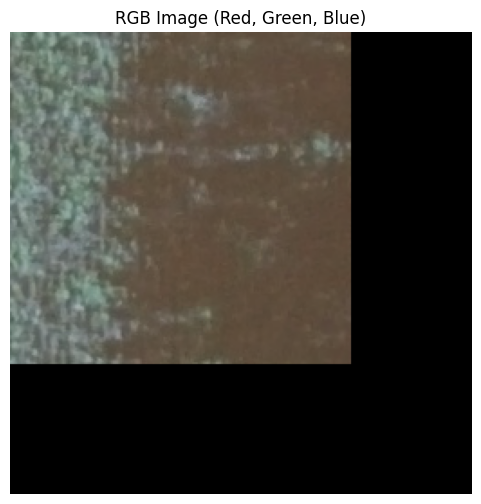

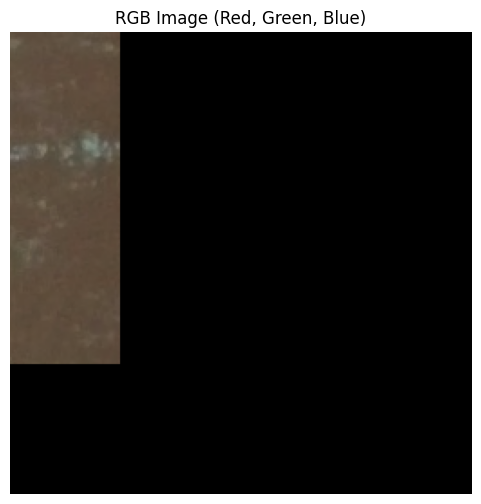

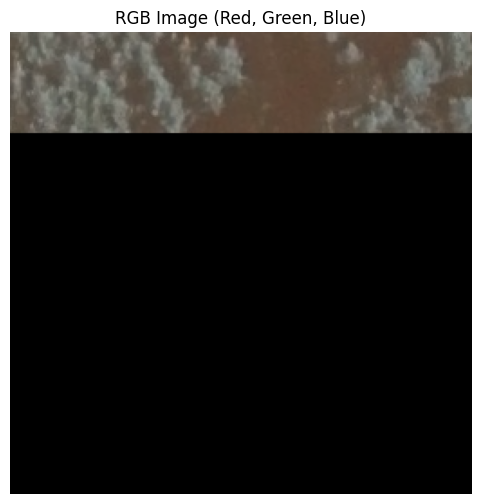

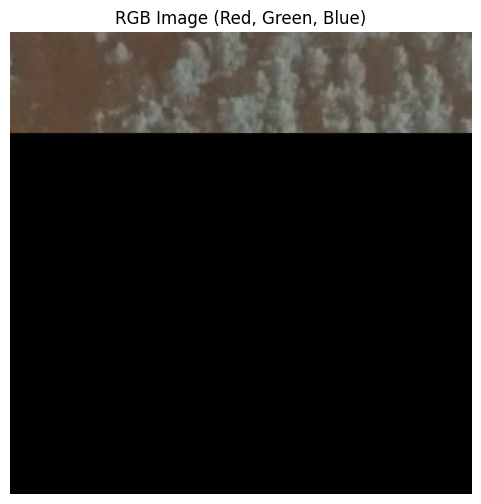

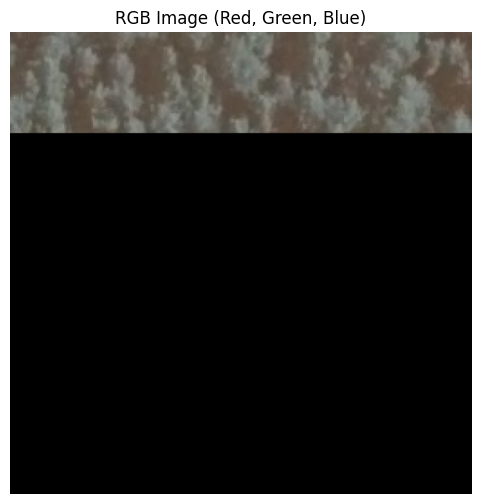

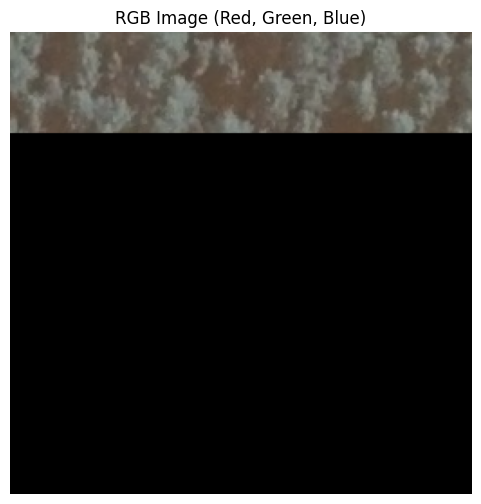

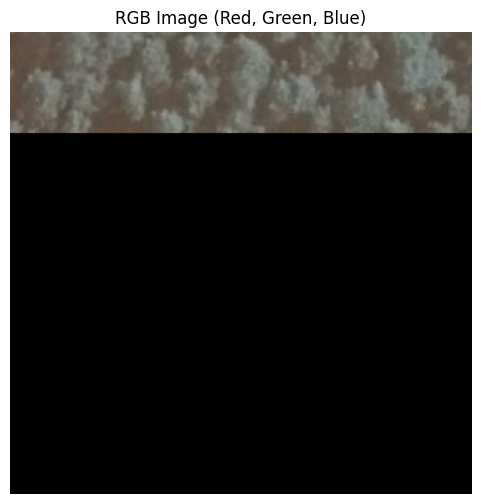

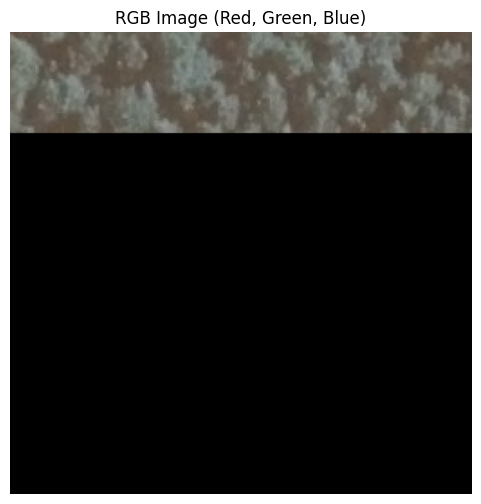

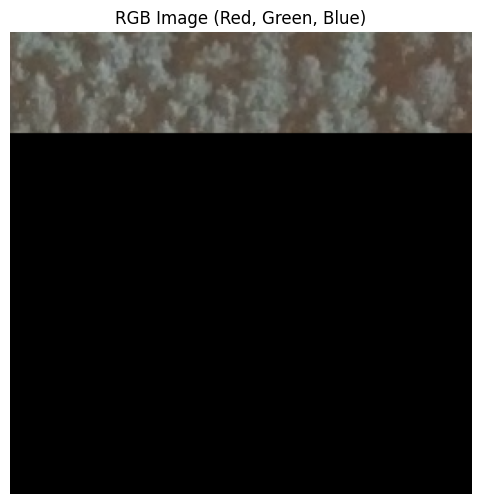

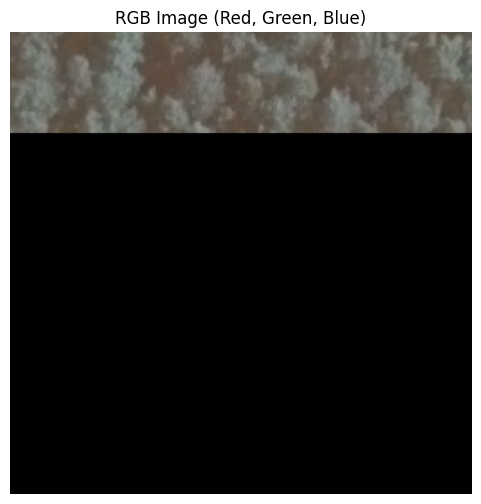

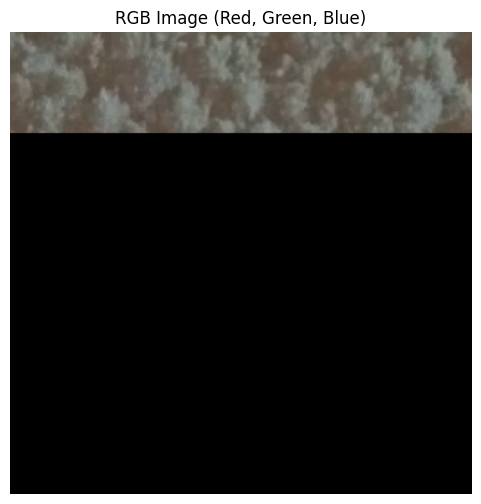

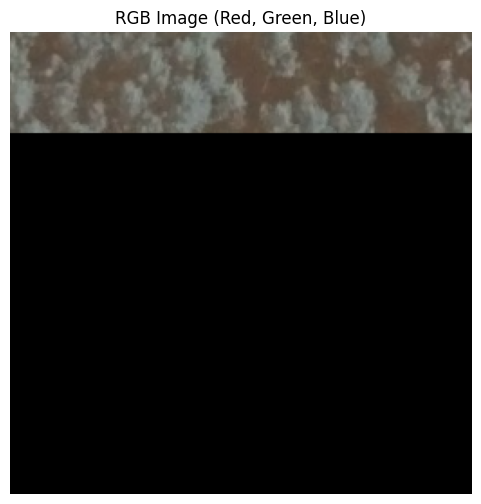

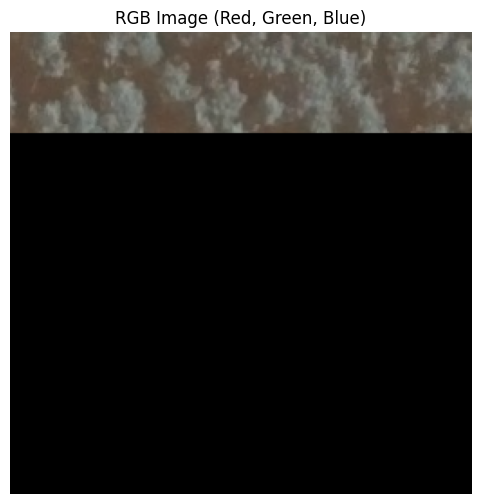

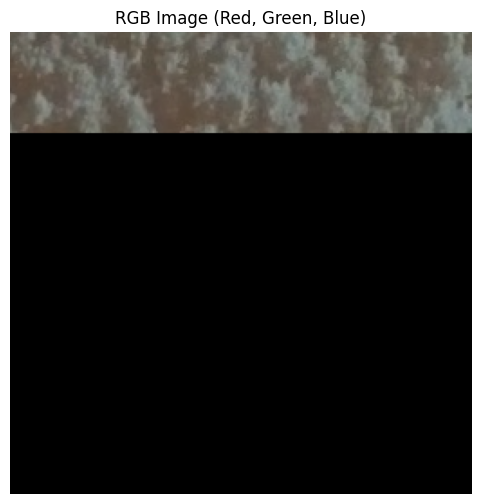

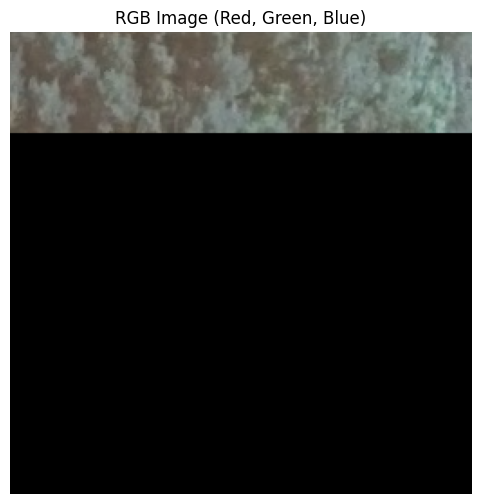

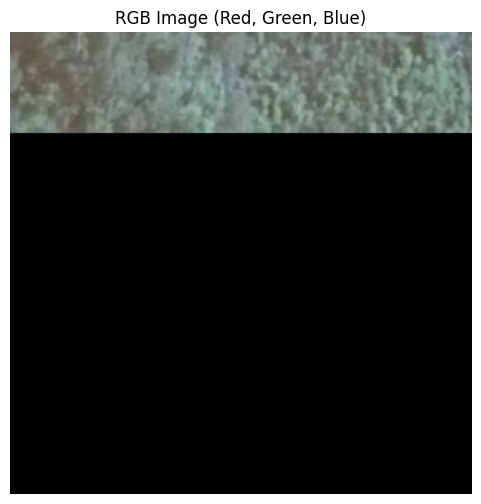

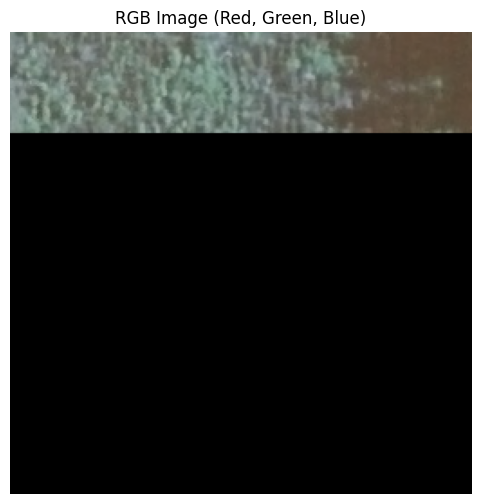

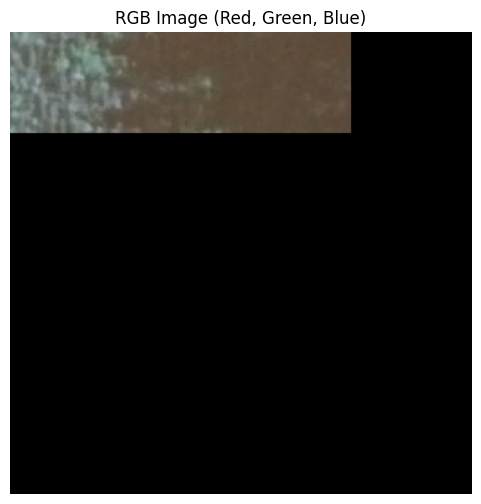

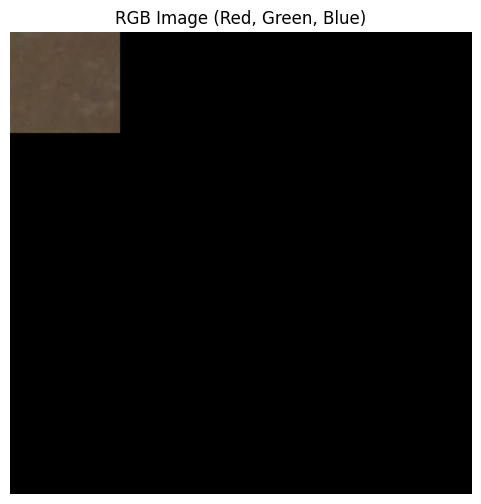

In [96]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'image_data' is your (4, 256, 256) image tensor with bands: NIR, Red, Green, Blue.
# Example: image_data = np.random.rand(4, 256, 256) if you don't have the actual data.

# Plotting the RGB image (Red, Green, Blue channels)
def plot_rgb(image_data):
    rgb_image = np.stack((image_data[1], image_data[2], image_data[3]), axis=-1)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(rgb_image)
    plt.title('RGB Image (Red, Green, Blue)')
    plt.axis('off')
    plt.show()

# Plotting the NIR + RGB image (NIR, Green, Blue channels)
def plot_nir_rgb(image_data):
    nir_rgb_image = np.stack((image_data[0], image_data[2], image_data[3]), axis=-1)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(nir_rgb_image)
    plt.title('NIR + RGB Image (NIR, Green, Blue)')
    plt.axis('off')
    plt.show()

# Call the functions to plot
for patch in patches:
    plot_rgb(patch)    # Plot RGB Image

#plot_nir_rgb(patches[4]) # Plot NIR + RGB Image


In [6]:
import geopandas as gpd
import os
from pathlib import Path
from tqdm import tqdm  # For progress bar

# Root directory containing year folders
root_dir = Path('/Users/anisr/Documents/dead_trees/Poland/RGBNIR/25cm')

iou_results = {}

# Define the projected CRS
projected_crs = 'EPSG:3857'

# Loop through each year directory in the root directory
for year_dir in root_dir.iterdir():
    if year_dir.is_dir():  # Ensure it's a directory
        year = year_dir.name
        
        # Define paths for Geojsons and Predictions subdirectories
        geojson_dir = year_dir / 'Geojsons'
        prediction_dir = year_dir / 'Predictions'
        
        if geojson_dir.exists() and prediction_dir.exists():
            print(f"Processing year: {year}")
            
            # Process each GeoJSON file in the Geojsons directory
            for geojson_file in tqdm(os.listdir(geojson_dir), desc=f"Processing {year}"):
                if geojson_file.endswith('.geojson'):
                    geojson_path = geojson_dir / geojson_file
                    prediction_path = prediction_dir / geojson_file
                    
                    if prediction_path.exists():
                        try:
                            # Read both GeoDataFrames
                            gdf = gpd.read_file(geojson_path)
                            gdf_p = gpd.read_file(prediction_path)
                            
                            # If either GeoDataFrame is not valid, continue to next file
                            if not isinstance(gdf, gpd.GeoDataFrame) or not isinstance(gdf_p, gpd.GeoDataFrame):
                                print(f"Skipping {geojson_file} because one of the files is not a valid GeoDataFrame.")
                                continue
                            
                            # Transform both to the projected CRS
                            gdf = gdf.to_crs(projected_crs)
                            gdf_p = gdf_p.to_crs(projected_crs)

                            intersection = gpd.overlay(gdf, gdf_p, how='intersection', keep_geom_type=False)
                            union = gpd.overlay(gdf, gdf_p, how='union', keep_geom_type=False)

                            # Optionally filter to keep only Polygon/MultiPolygon geometries
                            intersection = intersection[intersection.geometry.type.isin(['Polygon', 'MultiPolygon'])]
                            union = union[union.geometry.type.isin(['Polygon', 'MultiPolygon'])]
                            
                            # Safeguard against empty geometries
                            if not intersection.empty and not union.empty:
                                intersection_area = intersection.geometry.area.sum()
                                union_area = union.geometry.area.sum()
                                
                                # Compute IoU
                                iou = intersection_area / union_area if union_area > 0 else 0
                            else:
                                iou = 0  # In case of empty geometries
                            
                            # Store the IoU result with year prefix
                            iou_results[f"{year}/{geojson_file}"] = iou

                        except Exception as e:
                            print(f"Error processing {year}/{geojson_file}: {e}")
                    else:
                        print(f"Prediction file not found for: {year}/{geojson_file}")
        else:
            print(f"Geojsons or Predictions directory missing for year: {year}")

# Print IoU Results
print("\nIoU Results:")
for filename, iou in iou_results.items():
    print(f"{filename}: {iou:.4f}")

# Compute and print the mean IoU
if iou_results:
    mean_iou = sum(iou_results.values()) / len(iou_results)
    print(f"\nMean IoU: {mean_iou:.4f}")
else:
    print("No IoU values to compute the mean.")

Processing year: 2022


Processing 2022: 100%|██████████| 40/40 [00:02<00:00, 15.61it/s]


Processing year: 2021


Processing 2021:   7%|▋         | 1/15 [00:00<00:01,  8.01it/s]/Users/anisr/Documents/TreeSeg/venv/lib/python3.9/site-packages/shapely/constructive.py:532: RuntimeWarning: invalid value encountered in make_valid
  return lib.make_valid(geometry, **kwargs)
Processing 2021: 100%|██████████| 15/15 [00:00<00:00, 19.69it/s]


IoU Results:
2022/N-34-82-C-a-4-4_0.geojson: 0.1102
2022/N-34-90-A-a-1-3_1.geojson: 0.0885
2022/N-34-81-B-a-4-2_0.geojson: 0.4287
2022/M-34-65-C-d-1-1_0.geojson: 0.0000
2022/M-34-56-B-d-3-2_1.geojson: 0.0000
2022/M-34-29-C-c-2-1_0.geojson: 0.1313
2022/N-34-106-D-b-2-2_0.geojson: 0.0000
2022/N-34-90-A-a-3-1_1.geojson: 0.0110
2022/N-34-90-A-c-1-1_1.geojson: 0.0000
2022/M-34-56-B-d-2-1_1.geojson: 0.0783
2022/N-34-90-A-a-1-4_1.geojson: 0.1295
2022/M-34-76-D-c-3-1_0.geojson: 0.0000
2022/M-34-70-D-c-2-2_0.geojson: 0.0000
2022/M-34-29-B-b-2-2_0.geojson: 0.0000
2022/M-34-55-A-c-1-3_0.geojson: 0.0000
2022/N-34-90-A-a-2-3_1.geojson: 0.0180
2022/N-34-104-B-d-2-3_1.geojson: 0.0000
2022/M-34-105-B-b-2-2_1.geojson: 0.0689
2022/M-34-52-C-c-4-2_0.geojson: 0.0000
2022/M-34-57-A-c-1-1_1.geojson: 0.0000
2022/N-34-94-A-d-2-3_0.geojson: 0.0000
2022/N-34-104-B-c-4-4_1.geojson: 0.1656
2022/M-34-93-A-b-4-1_0.geojson: 0.0000
2022/N-34-120-C-c-3-2_1_0.geojson: 0.1003
2022/N-34-70-A-c-2-3_0.geojson: 0.0000
2022

In [5]:
iou_results['2022/M-34-105-B-b-3-1_1.geojson']

np.float64(0.14682524532895305)

In [2]:
from treemort.utils.config import setup

config_file_path = "../configs/flair_unet_bs8_cs256.txt"
conf = setup(config_file_path)

# Modified Config Variables for Local Execution; comment on HPC
conf.data_folder = "/Users/anisr/Documents/AerialImages"
conf.output_dir = os.path.join("..", conf.output_dir)

print(conf)

Namespace(data_folder='/Users/anisr/Documents/AerialImages', hdf5_file='AerialImageModel_ITD.h5', model='flair_unet', backbone=None, epochs=100, train_batch_size=8, val_batch_size=8, test_batch_size=8, train_crop_size=256, val_crop_size=256, test_crop_size=256, val_size=0.2, test_size=0.1, input_channels=4, output_channels=1, output_dir='../output/flair_unet', model_weights='best', learning_rate=0.0001, threshold=0.5, activation='tanh', loss='hybrid', resume=True)


In [3]:
import torch
import numpy as np
from skimage.measure import label, regionprops
from tqdm import tqdm

from treemort.training.output_processing import process_model_output

def calculate_geometric_properties(predictions):
    """
    Calculate basic geometric properties for each segmented dead tree.
    
    Args:
        predictions (torch.Tensor): A batch of binary segmentation masks of shape (N, H, W),
                                    where N is the batch size, H is height, and W is width.
                                    
    Returns:
        List of dictionaries containing geometric properties for each segmented object.
    """
    batch_properties = []
    
    # Convert tensor to numpy array for processing
    predictions = predictions.detach().cpu().numpy()
    
    for i in range(predictions.shape[0]):
        # Get binary mask for current prediction
        binary_mask = predictions[i].squeeze().astype(np.uint8)
        
        # Label connected components in the binary mask
        labeled_mask = label(binary_mask)
        
        # Extract properties for each labeled region (i.e., each dead tree)
        regions = regionprops(labeled_mask)
        image_properties = []
        
        for region in regions:
            properties = {
                'Area': region.area,
                'Perimeter': region.perimeter,
                'Centroid': region.centroid,
                'BoundingBox': region.bbox,
                'AspectRatio': region.bbox[2] / region.bbox[3] if region.bbox[3] != 0 else 0
            }
            image_properties.append(properties)
        
        batch_properties.append(image_properties)
    
    return batch_properties


def evaluate_geometric_properties(model, data_loader, conf, device, image_processor, ):
    """
    Evaluate geometric properties for the entire dataset using the trained model.
    
    Args:
        model: Trained segmentation model.
        data_loader: DataLoader for the dataset.
        conf: Configuration dictionary or object.
        device: Device to run the model on (e.g., 'cpu' or 'cuda').
        image_processor: Function or class to process model outputs.
    
    Returns:
        List of dictionaries containing geometric properties for all images in the dataset.
    """
    model.eval()
    all_geometric_properties = []
    all_geometric_properties_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Evaluating"):
            images = images.to(device)
            
            # Get model predictions
            predictions = process_model_output(model, images, conf, image_processor, labels, device=device)
            
            # Apply thresholding to get binary segmentation masks
            binary_masks = (predictions > 0.5).float()
            binary_labels = (labels > 0.5).float()
            
            # Calculate geometric properties
            geometric_properties = calculate_geometric_properties(binary_masks)
            all_geometric_properties.extend(geometric_properties)

            # Calculate geometric properties for labels
            geometric_properties = calculate_geometric_properties(binary_labels)
            all_geometric_properties_labels.extend(geometric_properties)
    
    return all_geometric_properties, all_geometric_properties_labels


In [4]:
from treemort.data.loader import prepare_datasets
from treemort.modeling.builder import resume_or_load

id2label = {0: "alive", 1: "dead"}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset, val_dataset, test_dataset, image_processor = prepare_datasets(conf)

model, optimizer, criterion, metrics, callbacks = resume_or_load(conf, id2label, len(train_dataset), device)    


/Users/anisr/Documents/TreeSeg/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[INFO] Building model...
[INFO] FLAIR-UNet model configured with pre-trained weights.
[INFO] flair_unet model configured.
[INFO] Model successfully moved to cpu.
[INFO] Adam optimizer configured with learning rate 0.0001.
[INFO] Loss function 'hybrid' and associated metrics configured.
[INFO] Loaded weights from ../output/flair_unet/best.weights.pth.


In [5]:
from treemort.evaluation.evaluator import evaluator

evaluator(
            model,
            dataset=test_dataset,
            num_samples=len(test_dataset),
            batch_size=conf.test_batch_size,
            threshold=conf.threshold,
            model_name=conf.model,
            image_processor=image_processor,
        )

Evaluating: 100%|██████████| 76/76 [01:09<00:00,  1.10it/s, iterations_left=0] 

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5839793214884254e-09, 0.0, 9.250693793477618e-10, 1.0090817346023393e-09, 3.3670033556666553e-09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3474178348652164e-09, 2.3474178348652164e-09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.019367990805945e-09, 5.282620176818478e-10, 0.0, 8.012820506399982e-10, 2.9761904673327665e-09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.3474178348652164e-09, 2.3474178348652164e-09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.6835016806675055e-09, 1.2315270920794002e-09, 3.891050568517313e-09, 0.0, 0.0, 2.5641024983563464e-08, 0.0, 0.0, 1.149425274144537e-08, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0485829795603925e-09, 4.0485829795603925e-09, 0.0, 1.84

In [25]:
geometric_properties, geometric_properties_labels = evaluate_geometric_properties(model, test_dataset, conf, device, image_processor)

Evaluating: 100%|██████████| 76/76 [05:15<00:00,  4.15s/it]


In [31]:
for i, x in enumerate(geometric_properties_labels):
    if x != []:
        print(i, x)

45 [{'Area': 80.0, 'Perimeter': 32.242640687119284, 'Centroid': (211.375, 252.1375), 'BoundingBox': (206, 249, 218, 256), 'AspectRatio': 0.8515625}, {'Area': 307.0, 'Perimeter': 70.04163056034261, 'Centroid': (248.01954397394138, 239.62540716612378), 'BoundingBox': (238, 230, 256, 254), 'AspectRatio': 1.0078740157480315}]
47 [{'Area': 98.0, 'Perimeter': 34.72792206135785, 'Centroid': (187.4387755102041, 135.62244897959184), 'BoundingBox': (182, 131, 194, 141), 'AspectRatio': 1.375886524822695}, {'Area': 274.0, 'Perimeter': 76.38477631085024, 'Centroid': (206.8905109489051, 130.6897810218978), 'BoundingBox': (196, 121, 218, 141), 'AspectRatio': 1.5460992907801419}, {'Area': 146.0, 'Perimeter': 42.72792206135786, 'Centroid': (225.3972602739726, 142.23972602739727), 'BoundingBox': (219, 137, 233, 149), 'AspectRatio': 1.563758389261745}, {'Area': 256.0, 'Perimeter': 73.11269837220809, 'Centroid': (243.3203125, 152.8671875), 'BoundingBox': (231, 145, 256, 161), 'AspectRatio': 1.590062111801

In [36]:
id = 47
print(geometric_properties[id])
print(geometric_properties_labels[id])

[{'Area': 581.0, 'Perimeter': 112.5685424949238, 'Centroid': (201.2908777969019, 132.8382099827883), 'BoundingBox': (179, 119, 220, 144), 'AspectRatio': 1.5277777777777777}, {'Area': 7.0, 'Perimeter': 6.82842712474619, 'Centroid': (187.0, 124.28571428571429), 'BoundingBox': (186, 123, 189, 126), 'AspectRatio': 1.5}, {'Area': 176.0, 'Perimeter': 46.62741699796952, 'Centroid': (225.7215909090909, 141.76704545454547), 'BoundingBox': (219, 135, 234, 150), 'AspectRatio': 1.56}, {'Area': 226.0, 'Perimeter': 68.38477631085024, 'Centroid': (245.30088495575222, 152.00884955752213), 'BoundingBox': (233, 145, 256, 159), 'AspectRatio': 1.610062893081761}, {'Area': 242.0, 'Perimeter': 67.45584412271572, 'Centroid': (246.96280991735537, 111.14462809917356), 'BoundingBox': (237, 103, 256, 125), 'AspectRatio': 2.048}]
[{'Area': 98.0, 'Perimeter': 34.72792206135785, 'Centroid': (187.4387755102041, 135.62244897959184), 'BoundingBox': (182, 131, 194, 141), 'AspectRatio': 1.375886524822695}, {'Area': 274.

In [9]:
count = 0
for images, labels in train_dataset:
    for label in labels:
        if label.sum() > 0:
            count = count + 1

print(len(train_dataset)*8, count)

1056 500


In [7]:
t1 = 15367*conf.train_batch_size
t2 = 5567*conf.val_batch_size
t3 = 2426*conf.test_batch_size

print(t1, t2, t3)

t4 = 3606
t5 = t4 + t4*2
t6 = t4 + t4*7

print(t6, t5, t4)

print(t1+t2+t3, t4+t5+t6)

122936 44536 19408
28848 10818 3606
186880 43272


In [38]:
import numpy as np

def compare_properties(predicted, label):
    area_diff = abs(predicted['Area'] - label['Area'])
    perimeter_diff = abs(predicted['Perimeter'] - label['Perimeter'])
    aspect_ratio_diff = abs(predicted['AspectRatio'] - label['AspectRatio'])
    
    centroid_distance = np.linalg.norm(
        np.array(predicted['Centroid']) - np.array(label['Centroid'])
    )
    
    iou = calculate_iou(predicted['BoundingBox'], label['BoundingBox'])
    
    return {
        'Area Difference': area_diff,
        'Perimeter Difference': perimeter_diff,
        'Aspect Ratio Difference': aspect_ratio_diff,
        'Centroid Distance': centroid_distance,
        'IoU': iou
    }

def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# Example usage:
predicted_object = {'Area': 581.0, 'Perimeter': 112.5685424949238, 'Centroid': (201.2908777969019, 132.8382099827883), 'BoundingBox': (179, 119, 220, 144), 'AspectRatio': 1.5277777777777777}
label_object = {'Area': 98.0, 'Perimeter': 34.72792206135785, 'Centroid': (187.4387755102041, 135.62244897959184), 'BoundingBox': (182, 131, 194, 141), 'AspectRatio': 1.375886524822695}

comparison_results = compare_properties(predicted_object, label_object)
print(comparison_results)


{'Area Difference': 483.0, 'Perimeter Difference': 77.84062043356596, 'Aspect Ratio Difference': 0.15189125295508266, 'Centroid Distance': 14.129144508867478, 'IoU': 0.13095238095238096}


In [16]:
import streamlit as st
import geopandas as gpd

geojson_path = '/Users/anisr/Documents/TreeSeg/colab/geojson/M4124C_2017_1.geojson'

gdf = gpd.read_file(geojson_path)
gdf.geometry.centroid





0      POINT (341423.633 6801699.717)
1       POINT (341426.72 6801701.931)
2      POINT (341413.943 6801697.699)
3      POINT (341416.332 6801685.312)
4      POINT (341265.382 6801816.634)
                    ...              
115    POINT (341299.939 6801845.874)
116                       POINT EMPTY
117    POINT (341297.536 6801861.101)
118    POINT (341292.369 6801933.066)
119                       POINT EMPTY
Length: 120, dtype: geometry

GeoTIFF CRS: EPSG:3067
GeoJSON CRS: EPSG:3067
Number of geometries in GeoJSON: 120
Processing geometry: MULTIPOLYGON (((341422.18938091106 6801700.235113927, 341422.18938091106 6801700.277434435, 341422.18938091106 6801700.319754942, 341422.18938091106 6801700.362075449, 341422.18938091106 6801700.404395957, 341422.21054116474 6801700.446716464, 341422.252861672 6801700.489036971, 341422.2740219257 6801700.552517732, 341422.29518217937 6801700.615998493, 341422.316342433 6801700.679479254, 341422.3586629403 6801700.721799761, 341422.4009834476 6801700.764120269, 341422.4433039549 6801700.806440776, 341422.48562446225 6801700.848761283, 341422.52794496954 6801700.869921537, 341422.5702654769 6801700.869921537, 341422.65490649146 6801700.933402298, 341422.7183872524 6801700.933402298, 341422.80302826705 6801700.954562551, 341422.9088295353 6801700.996883059, 341422.9723102963 6801700.996883059, 341423.09927181824 6801700.996883059, 341423.1415923255 6801700.996883059, 341423.26855384745 

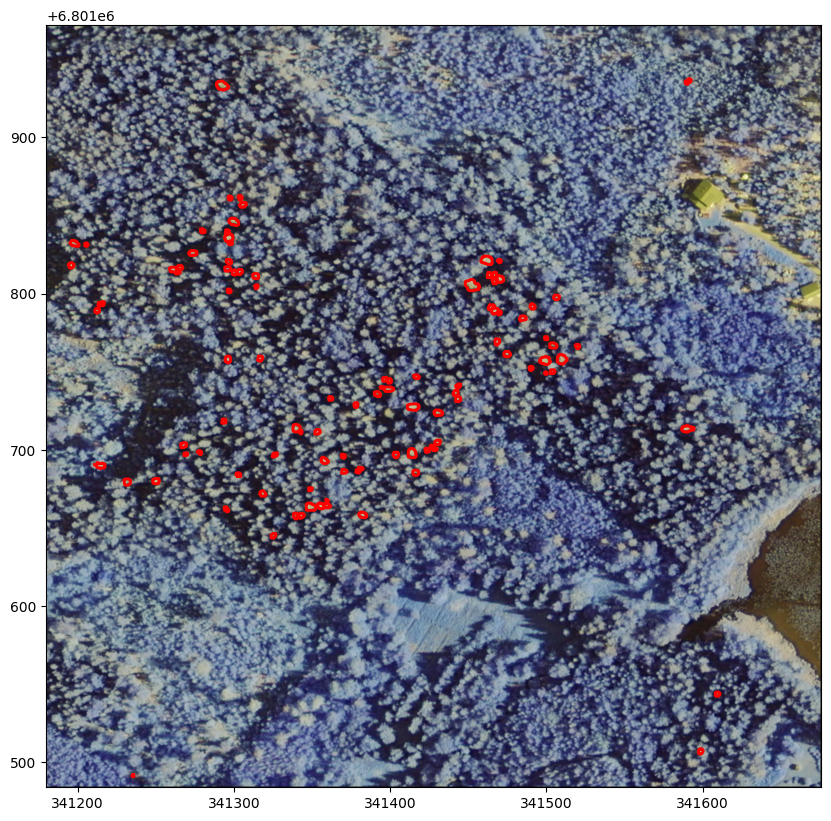

In [22]:
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import mapping
import numpy as np
import matplotlib.patches as patches

# Ensure inline plotting in Jupyter
%matplotlib inline

def overlay_tiff_geojson(tiff_path, geojson_path):
    try:
        # Read the GeoTIFF file
        with rasterio.open(tiff_path) as src:
            fig, ax = plt.subplots(figsize=(10, 10))
            
            # Read the image data
            nir = src.read(1)  # NIR channel
            red = src.read(2)  # Red channel
            green = src.read(3)  # Green channel
            blue = src.read(4)  # Blue channel
            
            # Create an RGB composite (NIR-RGB composite example)
            composite = np.dstack((nir, red, blue))  # Example: NIR as red, red as green, blue as blue
            
            # Normalize the composite for display
            composite = (composite - composite.min()) / (composite.max() - composite.min())
            
            # Display the composite image
            ax.imshow(composite, extent=(src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top))
            
            # Read the GeoJSON file
            gdf = gpd.read_file(geojson_path)
            
            # Check CRS and reproject if necessary
            if gdf.crs != src.crs:
                gdf = gdf.to_crs(src.crs)
            
            # Debugging: Print some information
            print(f"GeoTIFF CRS: {src.crs}")
            print(f"GeoJSON CRS: {gdf.crs}")
            print(f"Number of geometries in GeoJSON: {len(gdf)}")

            # Overlay polygons
            for _, row in gdf.iterrows():
                geom = row['geometry']
                if geom.is_valid:
                    # Debugging: Print geometry information
                    print(f"Processing geometry: {geom}")
                    if geom.geom_type == 'Polygon':
                        patch = patches.Polygon(list(geom.exterior.coords), linewidth=2, edgecolor='red', facecolor='none')
                        ax.add_patch(patch)
                    elif geom.geom_type == 'MultiPolygon':
                        for poly in geom.geoms:
                            patch = patches.Polygon(list(poly.exterior.coords), linewidth=2, edgecolor='red', facecolor='none')
                            ax.add_patch(patch)
            
            # Display the result
            plt.show()
    
    except Exception as e:
        print(f"An error occurred: {e}")



# Example usage:
overlay_tiff_geojson('./geojson_files/M4124C_2017_1.tiff', './geojson_files/M4124C_2017_1.geojson')
